<h1><center>Foundation of Machine Learning</center></h1>
<h2>
<hr style=" border:none; height:3px;">
<center>Project : Spotify Recommender</center>
<hr style=" border:none; height:3px;">
</h2>

### Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
import sklearn 
from sklearn import model_selection
import Recommenders
import Evaluation
import random as rd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

# Prepare the Dataset

In [2]:
# Read the data
df = pd.read_csv('final.csv', index_col=0)

#Merge song title and artist_name columns to make a merged column
df['song'] = df['title'].map(str) + " - " + df['artist_name']   
#Drop unneccesary columns
df.drop(['title', 'artist_name'], axis=1, inplace=True)

In [3]:
# Minimal number of songs a user must have listened to be kept in our dataset
min_songs = 10
# Minimal number of times a song must have been listened to be kept in our dataset
min_listenings = 20

In [4]:
# Count how many songs each user listened to
df['user_n_songs'] = df.groupby('user_id')['song'].transform('count')

# Count how many users listened to each song
df['song_n_users'] = df.groupby('song')['user_id'].transform('count')

# Keep all the users that listened to at least n songs
df = df[df['user_n_songs'] >= min_songs].drop_duplicates()

# Keep only the songs that were listened by at least 10 users
df = df[df['song_n_users'] >= min_listenings].drop_duplicates()

In [5]:
df = df[['song', 'user_id', 'play_count']].sample(frac=1).reset_index(drop=True)
user_ids = df[['user_id']].drop_duplicates()

df.head()

,song,user_id,play_count
0,No Ordinary Love (Remastered LP Version) - Deftones,a0725af3a10a2b0b456f153cb9d02f86f99917db,3
1,Inside Job - Pearl Jam,1c79208b564f462654db4b0a905e9ff051515c07,2
2,Don't Panic - Coldplay,ec2ae1c124ea0232bc1b44e9fbd21b4c24a624b9,1
3,Genius - Kings Of Leon,cc729e9bfbf3ac75a4dcf6e458638d7a272b2ad2,1
4,Stay Loose - Belle & Sebastian,740b8e06c6297ef8864ef5badd69c1f68c37d6b1,1


# Recommenders

In this part, we will create, test and evaluate different model to give recommendations. The different recommender can be found in the file `Recommenders.py`, and the functions to evaluate the recommenders can be found in `Evaluation.py`.

In [6]:
seed = 123
sample_fraction = 0.7

# Create a train data set that contains a sample of the playlist of every users.
train_data = df.groupby('user_id', as_index=False)
train_data = train_data.apply(lambda user_songs: user_songs.sample(frac=sample_fraction, random_state=seed))

# Create an instance of the class Evaluation used to evaluate our models.
evaluation = Evaluation.Evaluation(user_ids, df, seed)

user_id = user_ids.sample(random_state=seed).iloc[0]['user_id']
print(user_id)
train_data[train_data['user_id'] == user_id][['song']].drop_duplicates()

2b8ae0e9460e362df2556a551978a4c340c32b5b


song
382 12673                      Sugar Coated Sour - The Dillinger Escape Plan
    2551   The Czar: Usurper/Escape/Martyr/Spiral (Album Version) - Mastodon
    18617                                         Hit The Lights - Metallica
    13544                       The Three-Dimensional Shadow - Scar Symmetry
    23713                                           Stickin In My Eye - NOFX
    5962      Kickstart My Heart (Album Version) - Between The Buried And Me
    4390                         When Will They Shoot? (Explicit) - Ice Cube

## Simple Recommender based on Popularity

This simple model recommends songs to users based only on their popularity. This is a first naive approach as it is not a personalized recommendation: all users will get the same recommendations.

In [7]:
reco_pop = Recommenders.PopularityRecommender(train_data)

# Example
reco_pop.recommend(user_id, 10)

,song,score,rank_pop
153,Check On It - Beyoncé feat. Slim Thug,333,1.0
975,Supermassive Black Hole (Album Version) - Muse,330,2.0
255,Don't Panic - Coldplay,326,3.0
76,Baby Boy [feat. Beyonce] - Sean Paul,287,4.0
742,One I Love - Coldplay,268,5.0
815,Ragoo - Kings Of Leon,247,6.0
13,A Dustland Fairytale - The Killers,238,7.0
716,Nothin' On You [feat. Bruno Mars] (Album Version) - B.o.B,237,8.0
193,Crawling (Album Version) - Linkin Park,219,9.0
53,Angie (1993 Digital Remaster) - The Rolling Stones,211,10.0


### Evaluation of the model

Accuracy of    the first suggestion  :    22.75% (0.20976481870027092, 0.2452468363113841)
Accuracy of the  5 first suggestions :    20.61% (0.19840568700551536, 0.21371552511569675)
Accuracy of the 10 first suggestions :    18.07% (0.1755501649505314, 0.18584843644807)
Accuracy of the 20 first suggestions :    15.43% (0.15091703826328387, 0.1577542904080448)


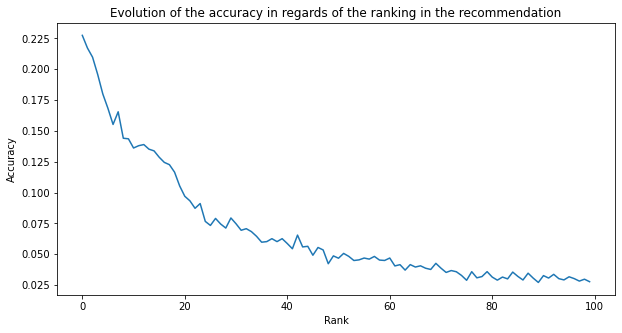

In [8]:
evaluation.evaluate(reco_pop.recommend)

## Recommender based on Item Similarity

This model recommends songs to users based on colaborative filtering on user item similarity.

In [8]:
reco_sim = Recommenders.ItemSimilarityRecommender(train_data)

# Example
reco_sim.recommend(user_id, 10)

,song,score,rank_sim
0,Crow Killer - Unearth,0.047619,1
1,The Mojo - J.B. Lenoir,0.030672,2
2,We March To The Beat Of Indifferent Drum - NOFX,0.030075,3
3,My Heart Is Yearning - NOFX,0.028833,4
4,The Chosen Legacy - Dimmu Borgir,0.028571,5
5,Infected - Bad Religion,0.020268,6
6,Warrior's Quest - Ensiferum,0.020000,7
7,The Plot To Bomb The Panhandle (Album Version) - A Day To Remember,0.019048,8
8,Why You Wanna Get Funky... - Del The Funky Homosapien,0.019048,9
9,Long Summer Days - The Moody Blues,0.017857,10


### Evaluation of the model

Accuracy of    the first suggestion  :    27.00% (0.1829855452491477, 0.35701445475085236)
Accuracy of the  5 first suggestions :    17.30% (0.1397811854174285, 0.20629527333508657)
Accuracy of the 10 first suggestions :    12.37% (0.10308600560895753, 0.14435775717222857)
Accuracy of the 20 first suggestions :    8.35% (0.07104443231691182, 0.0958847015413559)


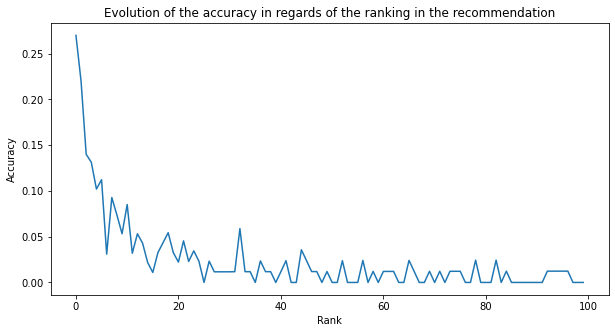

In [8]:
evaluation.evaluate(reco_sim.recommend, 100)

## Recommender based on Play Count

This model recommends songs to users based on play counts and by estimating the number of time the user would listen each music.

In [9]:
reco_play = Recommenders.PlayCountRecommender(train_data)

# Example
reco_play.recommend(user_id, 10)

,song,score,rank_play_count
0,We March To The Beat Of Indifferent Drum - NOFX,0.785906,1
1,The Mojo - J.B. Lenoir,0.593533,2
2,Patience - Guns N' Roses,0.347503,3
3,The Chosen Legacy - Dimmu Borgir,0.333333,4
4,Alright_ Alright_ Alright - Mungo Jerry,0.328305,5
5,Catholic Knees (Album Version) - Taking Back Sunday,0.320223,6
6,My Heart Is Yearning - NOFX,0.317466,7
7,Trade It All PT2 (Early Fade Amended Version- Bonus Track) (featuring P. Diddy & Jagged Edge) - Fabolous,0.316228,8
8,Witchcraft (1997 Digital Remaster) - Joe Graves & The Diggers,0.316228,9
9,Starlight - Snowgoons,0.316228,10


### Evaluation of the model

Accuracy of    the first suggestion  :    14.50% (0.09620221022958342, 0.19379778977041656)
Accuracy of the  5 first suggestions :    10.70% (0.08784131445594076, 0.12615868554405923)
Accuracy of the 10 first suggestions :    8.46% (0.07239030656745037, 0.09687921484312899)
Accuracy of the 20 first suggestions :    5.97% (0.05225292824446586, 0.0671886436273025)


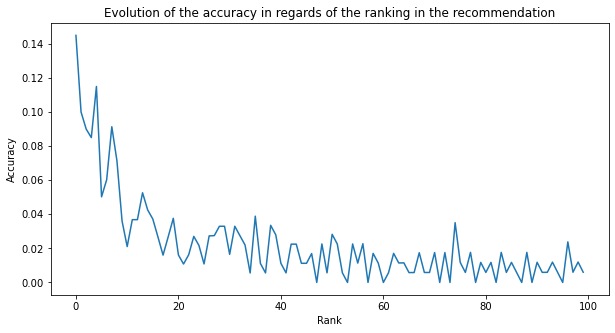

In [11]:
evaluation.evaluate(reco_play.recommend, 200)

## Recommender combined

This model is a combination of the 3 previous model. Each score previous computed is standardized and multiplied with a weight-factor to create a new combined score. These factor must be computed to maximize the accuracy.

In [10]:
# Very long to run, prefer to load the data from reco_df.csv
reco_df = Recommenders.generate_reco_dataset(df, train_data, user_ids, reco_pop, reco_sim, reco_play, 150, seed)
reco_df.to_csv('reco_df.csv')
reco_df.head(10)

[1/150]
[2/150]
[3/150]
[4/150]
[5/150]
[6/150]
[7/150]
[8/150]
[9/150]
[10/150]
[11/150]
[12/150]
[13/150]
[14/150]
[15/150]
[16/150]
[17/150]
[18/150]
[19/150]
[20/150]
[21/150]
[22/150]
[23/150]
[24/150]
[25/150]
[26/150]
[27/150]
[28/150]
[29/150]
[30/150]
[31/150]
[32/150]
[33/150]
[34/150]
[35/150]
[36/150]
[37/150]
[38/150]
[39/150]
[40/150]
[41/150]
[42/150]
[43/150]
[44/150]
[45/150]
[46/150]
[47/150]
[48/150]
[49/150]
[50/150]
[51/150]
[52/150]
[53/150]
[54/150]
[55/150]
[56/150]
[57/150]
[58/150]
[59/150]
[60/150]
[61/150]
[62/150]
[63/150]
[64/150]
[65/150]
[66/150]
[67/150]
[68/150]
[69/150]
[70/150]
[71/150]
[72/150]
[73/150]
[74/150]
[75/150]
[76/150]
[77/150]
[78/150]
[79/150]
[80/150]
[81/150]
[82/150]
[83/150]
[84/150]
[85/150]
[86/150]
[87/150]
[88/150]
[89/150]
[90/150]
[91/150]
[92/150]
[93/150]
[94/150]
[95/150]
[96/150]
[97/150]
[98/150]
[99/150]
[100/150]
[101/150]
[102/150]
[103/150]
[104/150]
[105/150]
[106/150]
[107/150]
[108/150]
[109/150]
[110/150]
[111/150

,song,score_pop,score_sim,score_play_count,correct,user_id
0,Check On It - Beyoncé feat. Slim Thug,1.000000,0.040208,0.034691,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
1,Supermassive Black Hole (Album Version) - Muse,0.990964,0.150689,0.119537,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
2,Don't Panic - Coldplay,0.978916,0.070284,0.040609,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
3,Baby Boy [feat. Beyonce] - Sean Paul,0.861446,0.061039,0.041898,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
4,One I Love - Coldplay,0.804217,0.028794,0.021629,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
5,Ragoo - Kings Of Leon,0.740964,0.040565,0.023962,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
6,A Dustland Fairytale - The Killers,0.713855,0.060472,0.022632,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
7,Nothin' On You [feat. Bruno Mars] (Album Version) - B.o.B,0.710843,0.114087,0.064207,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
8,Crawling (Album Version) - Linkin Park,0.656627,0.137907,0.084441,0,2b8ae0e9460e362df2556a551978a4c340c32b5b
9,Angie (1993 Digital Remaster) - The Rolling Stones,0.632530,0.162489,0.061077,0,2b8ae0e9460e362df2556a551978a4c340c32b5b


In [39]:
reco_df = pd.read_csv('reco_df.csv', index_col=0)
reco_df.head(10)

,song,score_pop,score_sim,score_play_count,correct
0,Supermassive Black Hole (Album Version) - Muse,1.000000,0.195071,0.069221,0
1,Don't Panic - Coldplay,0.975460,0.076090,0.040917,0
2,Check On It - Beyoncé feat. Slim Thug,0.972393,0.106689,0.066623,0
3,Baby Boy [feat. Beyonce] - Sean Paul,0.880368,0.085821,0.021906,0
4,One I Love - Coldplay,0.819018,0.106638,0.063823,0
5,Ragoo - Kings Of Leon,0.782209,0.086302,0.039177,0
6,A Dustland Fairytale - The Killers,0.766871,0.121712,0.894044,0
7,Crawling (Album Version) - Linkin Park,0.711656,0.228473,0.081345,0
8,Angie (1993 Digital Remaster) - The Rolling Stones,0.680982,0.216521,0.130567,0
9,Nothin' On You [feat. Bruno Mars] (Album Version) - B.o.B,0.674847,0.233069,0.077268,0


## Create a model to predict the likeliness of a song to be listened

In [11]:
sample_users = reco_df[['user_id']].drop_duplicates()
X_train, X_test, y_train, y_test = train_test_split(reco_df[['user_id', 'song', 'score_pop', 'score_sim', 'score_play_count']], reco_df['correct'], train_size=sample_fraction, random_state=seed)

### Linear Regression

In [12]:
model = LinearRegression()
model.fit(X_train[['score_pop', 'score_sim', 'score_play_count']], y_train)

# Example
y_test_pred = model.predict(X_test[['score_pop', 'score_sim', 'score_play_count']])
res = pd.concat([X_test, y_test], axis = 1, join = 'outer', ignore_index=False, sort=False)
res = res.reset_index(drop=True)
res = pd.concat([res, pd.DataFrame(y_test_pred, columns=['predicted'])], axis = 1, join = 'outer', ignore_index=False, sort=False)
res.head(10)

,user_id,song,score_pop,score_sim,score_play_count,correct,predicted
0,b60e78c1621248122b3d674b4e4388980e83558d,Esquilo não samba - Móveis Coloniais de Acaju,0.006024,0.012921,0.053206,0,-0.000854
1,7359862b9c115066390022c13e7d338648abd39d,Show You How - The Killers,0.391566,0.586061,0.612875,0,0.059575
2,7359862b9c115066390022c13e7d338648abd39d,124 - Photek,0.006024,0.000000,0.000000,0,-0.002919
3,85938b232ddb94b062c73410b0a8a5487bb07c0c,Soul - Pedro Luis e a Parede,0.009036,0.000000,0.000000,0,-0.002860
4,e26faa6c892bd4ba6a2b5e0c99ca4a1697d7175b,Chitlins Con Carne - Stevie Ray Vaughan And Double Trouble,0.036145,0.067297,0.014180,0,0.002774
5,f71229a198e9475110eea9f3215b5f7e0ffe9083,Love Don't Love Me (Justin Timberlake) (Amended Version) - Justin Timberlake,0.012048,0.004805,0.003567,0,-0.002382
6,e4f20eab574fdda5e208de70cd804a6eff91c5e8,Praying For Time - George Michael,0.006024,0.000000,0.000000,0,-0.002919
7,7c2157583f18154f067c0019e6f3fdc63529f703,Music For The Head - Porcupine Tree,0.009036,0.014254,0.011393,0,-0.001598
8,1d536e089f7a9285c5c03ce9603c0b55df3a130a,Setanta matins - Elena,0.021084,0.141140,0.017937,0,0.007829
9,03699fa50d944261dd0fe6eb6c4b58cbb44bdae5,Sahti Waari - Turisas,0.009036,0.000000,0.000000,0,-0.002860


Accuracy of    the first suggestion  :    21.33% (0.14777510700670338, 0.2788915596599633)
Accuracy of the  5 first suggestions :    10.27% (0.0809442024426494, 0.12438913089068394)
Accuracy of the 10 first suggestions :    6.73% (0.05465153780786823, 0.08001512885879843)
Accuracy of the 20 first suggestions :    5.07% (0.04281868471883753, 0.058514648614495804)


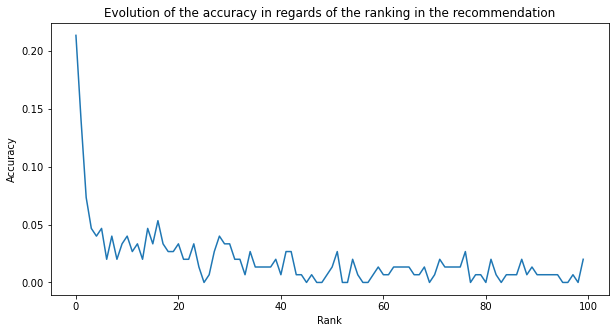

In [14]:
reco_mixed = Recommenders.MixedRecommenders(model, X_test)
sample_evaluation = Evaluation.Evaluation(sample_users, df, seed)
sample_evaluation.evaluate(reco_mixed.recommend)

### TODO

In [12]:
model = LinearRegression()
model.fit(X_train[['score_pop', 'score_sim', 'score_play_count']], y_train)

# Example
y_test_pred = model.predict(X_test[['score_pop', 'score_sim', 'score_play_count']])
res = pd.concat([X_test, y_test], axis = 1, join = 'outer', ignore_index=False, sort=False)
res = res.reset_index(drop=True)
res = pd.concat([res, pd.DataFrame(y_test_pred, columns=['predicted'])], axis = 1, join = 'outer', ignore_index=False, sort=False)
res.head(10)

,user_id,song,score_pop,score_sim,score_play_count,correct,predicted
0,b60e78c1621248122b3d674b4e4388980e83558d,Esquilo não samba - Móveis Coloniais de Acaju,0.006024,0.012921,0.053206,0,-0.000854
1,7359862b9c115066390022c13e7d338648abd39d,Show You How - The Killers,0.391566,0.586061,0.612875,0,0.059575
2,7359862b9c115066390022c13e7d338648abd39d,124 - Photek,0.006024,0.000000,0.000000,0,-0.002919
3,85938b232ddb94b062c73410b0a8a5487bb07c0c,Soul - Pedro Luis e a Parede,0.009036,0.000000,0.000000,0,-0.002860
4,e26faa6c892bd4ba6a2b5e0c99ca4a1697d7175b,Chitlins Con Carne - Stevie Ray Vaughan And Double Trouble,0.036145,0.067297,0.014180,0,0.002774
5,f71229a198e9475110eea9f3215b5f7e0ffe9083,Love Don't Love Me (Justin Timberlake) (Amended Version) - Justin Timberlake,0.012048,0.004805,0.003567,0,-0.002382
6,e4f20eab574fdda5e208de70cd804a6eff91c5e8,Praying For Time - George Michael,0.006024,0.000000,0.000000,0,-0.002919
7,7c2157583f18154f067c0019e6f3fdc63529f703,Music For The Head - Porcupine Tree,0.009036,0.014254,0.011393,0,-0.001598
8,1d536e089f7a9285c5c03ce9603c0b55df3a130a,Setanta matins - Elena,0.021084,0.141140,0.017937,0,0.007829
9,03699fa50d944261dd0fe6eb6c4b58cbb44bdae5,Sahti Waari - Turisas,0.009036,0.000000,0.000000,0,-0.002860
